In [1]:
import matplotlib.pyplot as plt
import scipy.integrate
import torch
import sys  
sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')

from hnn.simulation.pendulum import PendulumHamiltonianDynamics
from hnn.utils import integrate_model
from hnn.train import train
from hnn.types import TrajectoryArgs

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-4, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=2000, type=int, help='number of gradient steps')
    parser.add_argument('--field_type', default='both', type=str, help='type of vector field to learn') # solenoidal, conservative
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

In [3]:
args = get_args()

hamiltonian = PendulumHamiltonianDynamics()
data = hamiltonian.get_dataset({}, {})
model, stats = train(args, data)

Final train loss 2.5035e-02 +/- 1.0368e-02
Final test loss 2.5869e-02 +/- 1.1279e-02


In [4]:
R = 2.5
t_span=[0.0, 28.0]
Y0 = torch.tensor([2.1, 0.0])
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

traj_args = TrajectoryArgs(t_span=t_span, y0=Y0)
field_args = {
    'xmin': -R,
    'xmax': R,
    'ymin': -R,
    'ymax': R,
    'gridsize': 10,
}
field = hamiltonian.get_field(field_args)
vector_field = hamiltonian.get_vector_field(model, field_args)

/opt/homebrew/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:

ivp = integrate_model(
        model,
        t_span,
        y0=Y0,
        timescale=100,
        rtol=1e-12
)

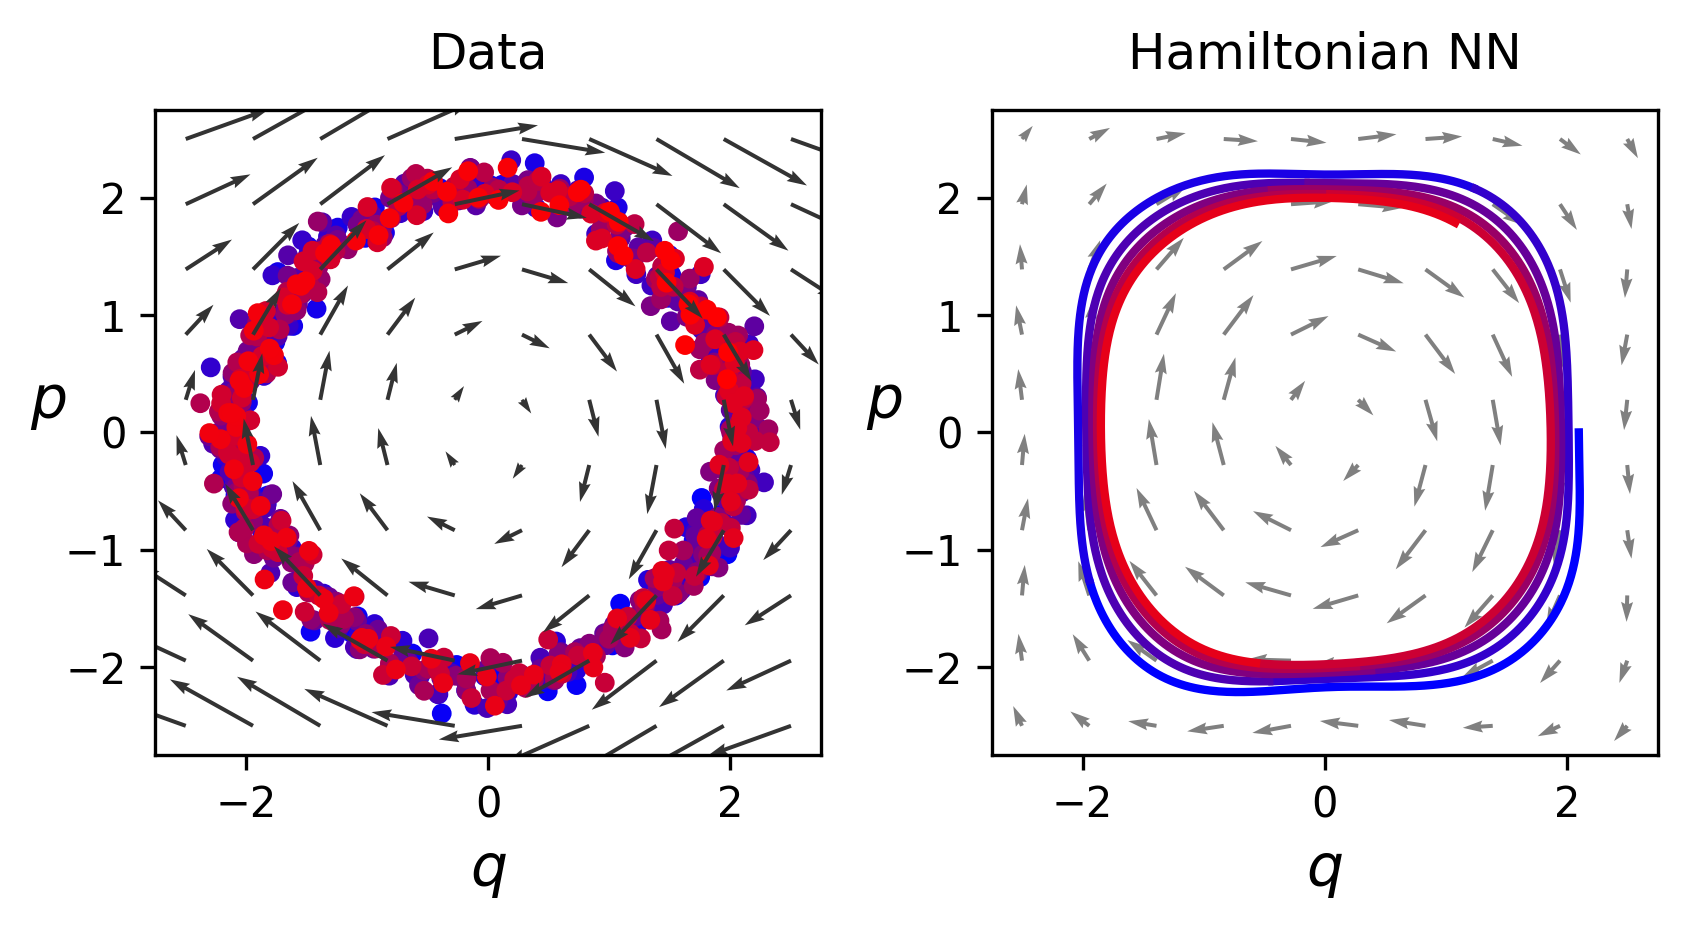

In [6]:
fig = plt.figure(figsize=(11.3, 3.2), facecolor='white', dpi=300)

# plot data
fig.add_subplot(1, 4, 1, frameon=True)
x, y, dx, dy, t = hamiltonian.get_trajectory(traj_args)
N = x.shape[1]
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x, y, s=14, label='data', c=point_colors)
plt.quiver(
        field.x[:,:,0],
        field.x[:,:,1],
        field.dx[:,0],
        field.dx[:,1],
        cmap='gray_r',
        scale=ARROW_SCALE,
        width=ARROW_WIDTH,
        color=(.2,.2,.2)
)  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot HNN-modeled data
fig.add_subplot(1, 4, 2, frameon=True)
plt.quiver(
        field.x[:,:,0],
        field.x[:,:,1],
        vector_field[:,:,0],
        vector_field[:,:,1],
        cmap='gray_r',
        scale=ARROW_SCALE,
        width=ARROW_WIDTH,
        color=(.5,.5,.5)
)

for i, l in enumerate(torch.tensor_split(ivp, LINE_SEGMENTS)):
        color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
        plt.plot(l[:, 0], l[:, 1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.tight_layout() ; plt.show()